In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCH=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


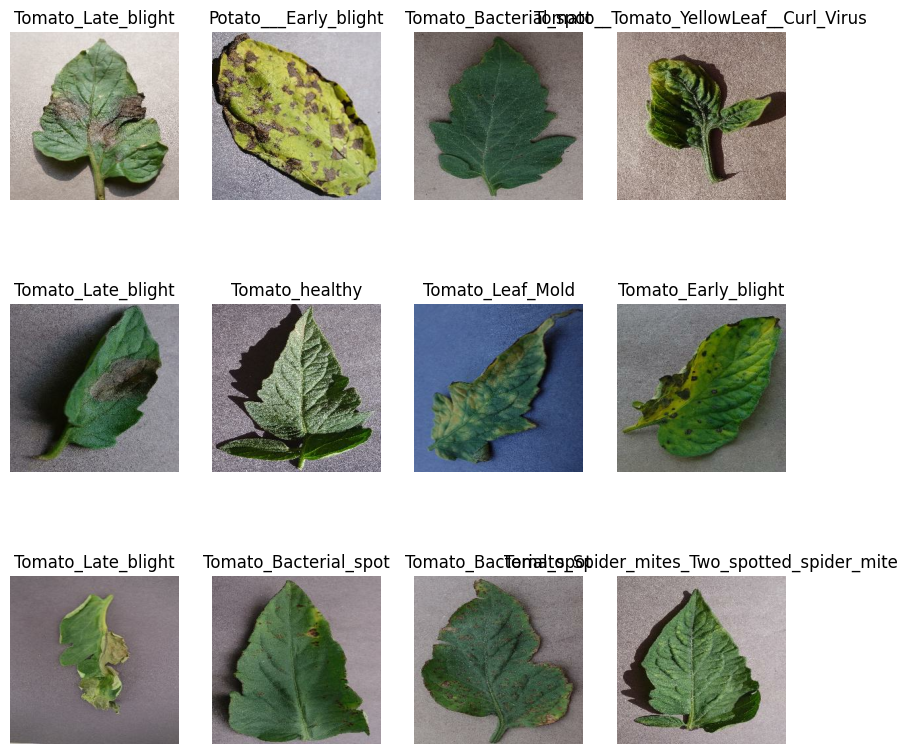

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCH, 
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
516/516 [==============================] - 181s 255ms/step - loss: 2.0562 - accuracy: 0.3221 - val_loss: 1.8325 - val_accuracy: 0.3843
Epoch 2/50
516/516 [==============================] - 75s 146ms/step - loss: 1.2309 - accuracy: 0.5876 - val_loss: 1.0357 - val_accuracy: 0.6362
Epoch 3/50
516/516 [==============================] - 50s 97ms/step - loss: 0.7857 - accuracy: 0.7297 - val_loss: 0.8511 - val_accuracy: 0.7056
Epoch 4/50
516/516 [==============================] - 57s 111ms/step - loss: 0.5869 - accuracy: 0.7946 - val_loss: 0.9403 - val_accuracy: 0.6997
Epoch 5/50
516/516 [==============================] - 55s 107ms/step - loss: 0.5070 - accuracy: 0.8239 - val_loss: 0.5241 - val_accuracy: 0.8203
Epoch 6/50
516/516 [==============================] - 58s 113ms/step - loss: 0.4112 - accuracy: 0.8594 - val_loss: 0.4808 - val_accuracy: 0.8398
Epoch 7/50
516/516 [==============================] - 63s 122ms/step - loss: 0.3710 - accuracy: 0.8740 - val_loss: 0.4272 - val_ac

In [16]:
score = model.evaluate(test_ds)

65/65 [==============================] - 61s 47ms/step - loss: 0.1585 - accuracy: 0.9553


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

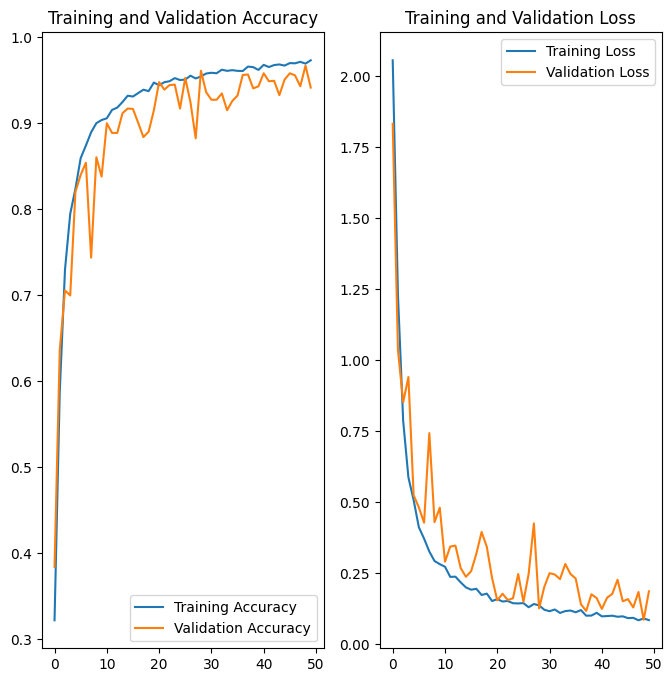

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to show
actual label: Tomato_Late_blight
predicted label: Tomato_Early_blight


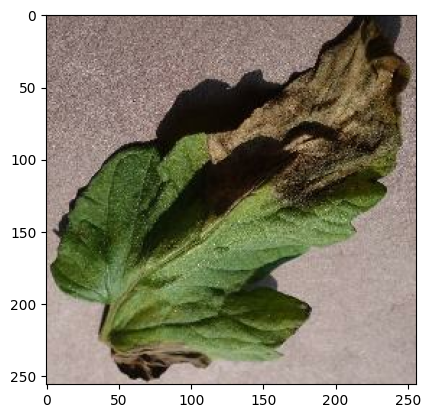

In [19]:
import numpy as np
for images_batch, label_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('int'))
    first_label = label_batch[0].numpy()
    
    print("first image to show")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0)
    
    predictions = model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

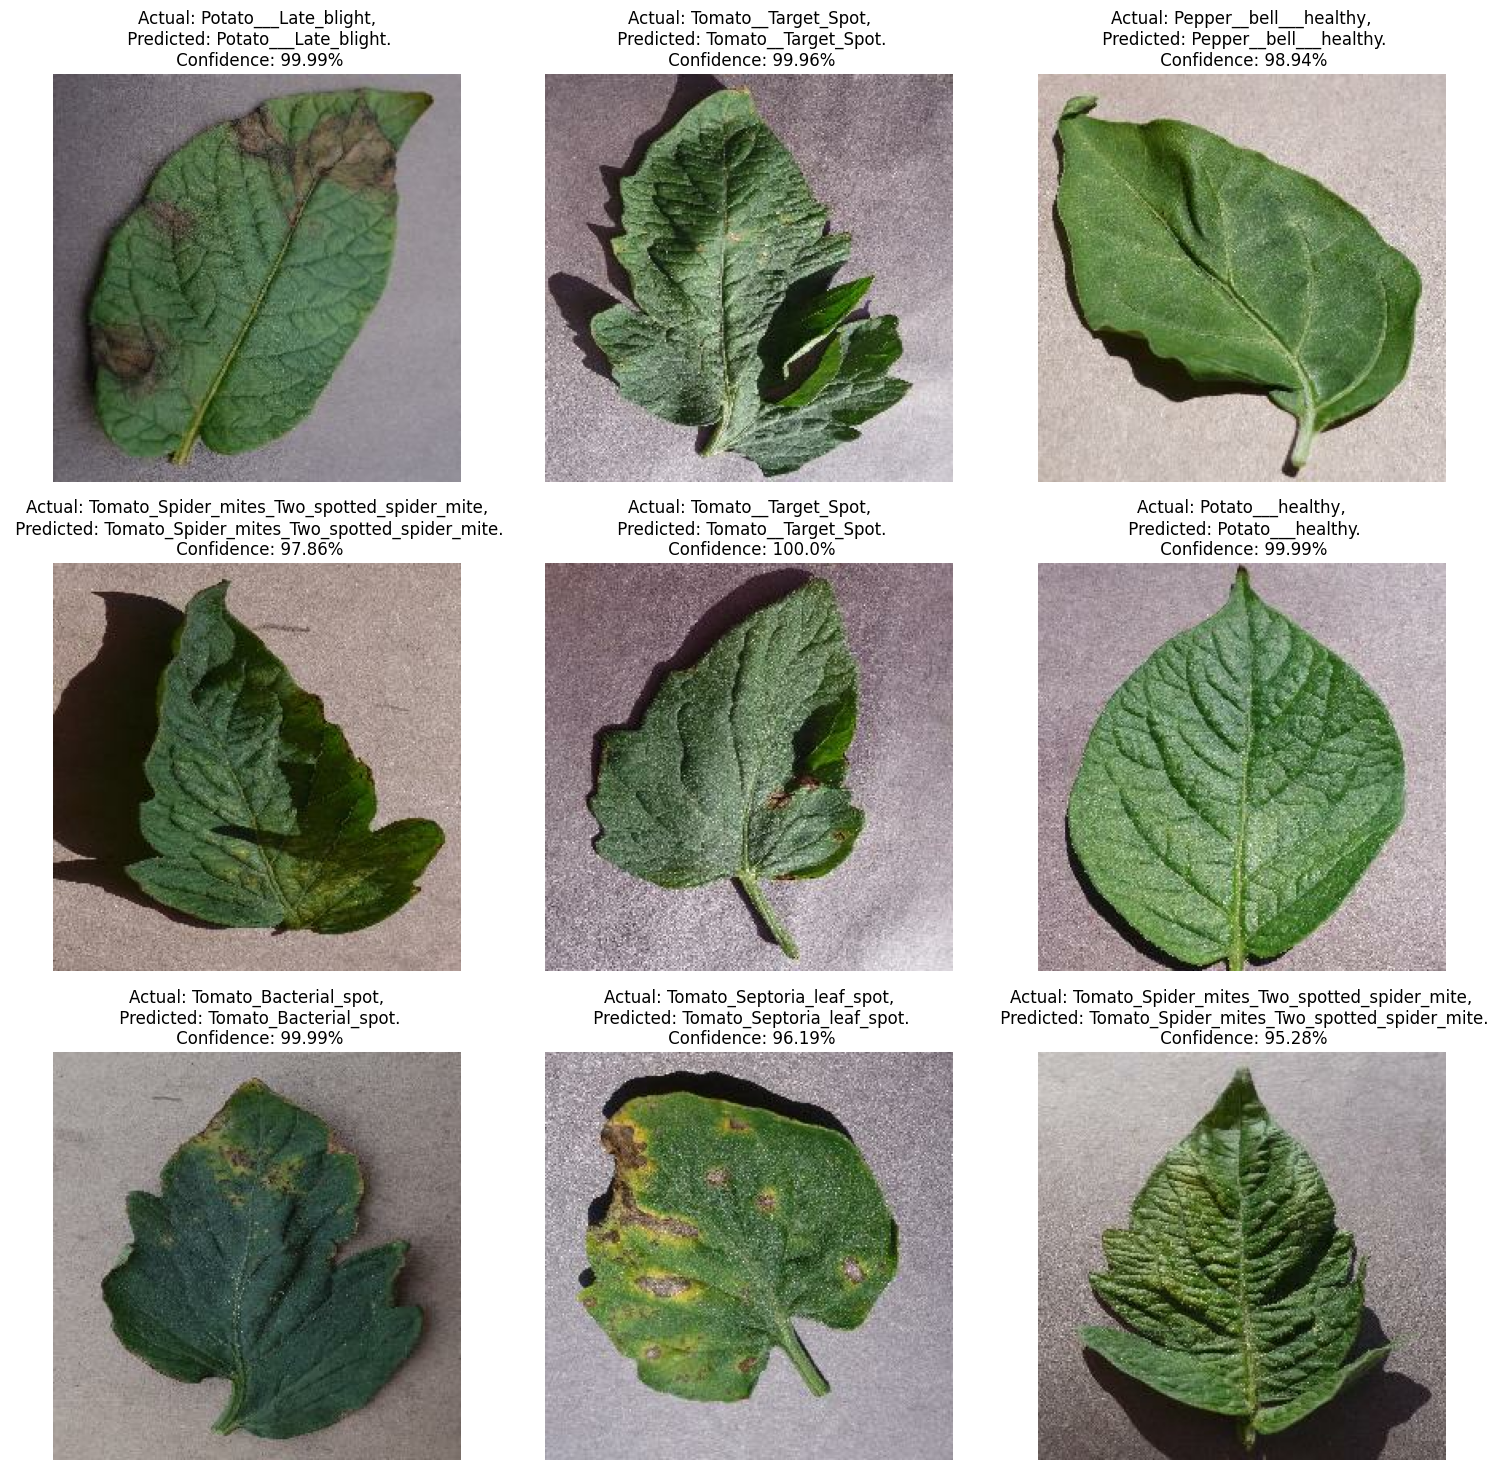

In [21]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [22]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [23]:
tf.keras.models.save_model(model,'my_model2.hdf5')

In [25]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('/Plant Village self final/training/my_model2.hdf5')
    return model

model=load_model()
st.write("""
        # Plant disease classification
        """)

file = st.file_uploader("Please Upload a leaf image", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np

def import_and_predict(image_data, model):
    size=(256, 256)
    image=ImageOps.fit(image_data, size, Image.ANTIALIAS)
    img=np.asarray(image)
    img_reshape = img[np.newaxis,...]
    prediction=model.predict(img_reshape)
    return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image=Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    CLASS_NAMES = ['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy'] 
    string="This output is : "+CLASS_NAMES[np.argmax(predictions)+" and the confidence is : "+np.argmax(predictions)]
    st.success(string)

Writing app.py


In [37]:
!ngrok config add-authtoken 2X1BoiBLZI8jgamY9gFLVWhaHvf_2iPxV3pKiAmXXm86KeuHW

Authtoken saved to configuration file: C:\Users\shiva\.ngrok2\ngrok.yml


In [38]:
!nohup streamlit run app.py &

OSError: Background processes not supported.

In [39]:
import os
from pyngrok import ngrok

ngrok.set_auth_token("2X1BoiBLZI8jgamY9gFLVWhaHvf_2iPxV3pKiAmXXm86KeuHW")

# Set the PYNGROK_CONFIG environment variable to disable TLS verification
os.environ["PYNGROK_CONFIG"] = '{"tunnels": {"tls_verify": false}}'

url = ngrok.connect(port=8051)



t=2023-10-20T13:15:45+0530 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=C:\\Users\\shiva\\AppData\\Local/ngrok/ngrok.yml legacy_path=C:\\Users\\shiva\\.ngrok2\\ngrok.yml
t=2023-10-20T13:15:46+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=423b3c5e2f05 err="failed to send authentication request: tls: failed to verify certificate: x509: certificate signed by unknown authority"
t=2023-10-20T13:15:47+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=423b3c5e2f05 err="failed to send authentication request: tls: failed to verify certificate: x509: certificate signed by unknown authority"
t=2023-10-20T13:15:49+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=423b3c5e2f05 err="failed to send authentication request: tls: failed to verify certificate: x509: certificate signed by unknown authority"
t=2023-10-20T13:15:52+0530 lvl=eror msg="failed to reconnect

PyngrokNgrokError: The ngrok process errored on start: failed to send authentication request: tls: failed to verify certificate: x509: certificate signed by unknown authority.